# 401 Assignment 1

## 1 Tuning Hyper-parameters

In [64]:
#imports
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn import datasets, tree, linear_model
from sklearn.model_selection import train_test_split, KFold
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 50,50

Several helper functions were created:
- get_average 
 - Simply returns the average result of a list
- scale_data
 - A small wrapper function for scaling data appropriately using sklearn's StandardScaler
- is_improvement
 - A function that calculates if the next iteration of the max_depth is a valid improvement. The formula requires that for any 1 increase in the average number of nodes, there should be at least a 1% in accuracy.

In [65]:
# helper functions

def get_average(arr):#returns the average of a python list
    s = 0
    for a in arr:
        s = s + a
    avg = s/len(arr)
    return avg

def scale_data(xtrain, xtest):#scales data using sklearns standard scaler
    feature_scaler = StandardScaler()
    return feature_scaler.fit_transform(xtrain), feature_scaler.transform(xtest)

def is_improvement(prev_accuracy, prev_num_nodes, current_accuracy, current_num_nodes):
    if (prev_accuracy is 0) and (prev_num_nodes is 0):
        return True
    prev_accuracy = prev_accuracy*100
    current_accuracy = current_accuracy*100
    accuracy_improvement = current_accuracy - prev_accuracy
    if accuracy_improvement<=0:
        return False
    node_delta = current_num_nodes - prev_num_nodes
    if accuracy_improvement < node_delta:
        return False
    return True
    

The k-fold cross validation was contained within a method.<br/>
This method takes the training data, as well as some optional parameters relating to the k-fold itself <br/>
The method works through max depths of 1 to 15<br/>
to achieve this the method runs a for loop through each depth in which it defines a new DecisionTreeClasifier. This DT is then KFolded and each set of test and training data within the k-fold is fitted to the tree, with the accuracy and number of nodes recorded. <br/>
For each max depth this is average and used to check if the classifier is a valid improvement.<br>
The method finally displays a dataframe and returns the best classifier

In [66]:
#KFold CV Method
def run_KFold_CV(x_train_kf, y_train_kf, n_splits=6, random_state = 0, shuffle = False):
    df = pd.DataFrame(columns=['Max_Tree_Depth', 'Average_Accuracy', 'Average_Node_Count'])
    depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    prev_avg_accuracy = 0
    prev_num_nodes = 0
    for depth in depths:
        kf_tree = tree.DecisionTreeClassifier(max_depth=depth)
        kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
        accuracy = []
        num_nodes = []
        for train_index, test_index in kf.split(x_train_kf):
            x_tr, x_te = x_train_kf[train_index], x_train_kf[test_index]
            y_tr, y_te = y_train_kf[train_index], y_train_kf[test_index]
            kf_tree = kf_tree.fit(x_tr, y_tr)
            predictions = kf_tree.predict(x_te)
            accuracy.append(kf_tree.score(x_te, y_te))
            num_nodes.append(kf_tree.tree_.node_count)
            acc_avg = get_average(accuracy)
            num_nodes_avg = get_average(num_nodes)
        df = df.append({'Max_Tree_Depth':depth, 'Average_Accuracy':acc_avg, 'Average_Node_Count': num_nodes_avg}, ignore_index=True)
        if is_improvement(prev_avg_accuracy, prev_num_nodes, acc_avg, num_nodes_avg):
            prev_avg_accuracy, prev_num_nodes = acc_avg, num_nodes_avg
            best_depth = depth
            best_tree = kf_tree
    display(df)
    print("The best classifier was found with depth ", best_depth)
    return best_tree

def test_best_tree(best_tree, x_te, y_te):
    predictions = best_tree.predict(x_te)
    accuracy = best_tree.score(x_te, y_te)
    print("The best classifier achieved an accuracy of ", accuracy, " on the test data")
    return
 
def train_best_tree(best_tree, x_tr, y_tr, x_te, y_te):
    kf_tree = best_tree
    
    kf_tree.fit(x_tr, y_tr)
    
    predictions = kf_tree.predict(x_te)
    accuracy = kf_tree.score(x_te, y_te)
    print("The best classifier achieved an accuracy of ", accuracy, " on the test data when fitted again with all training data")
    return

def retrain_best_tree(best_tree, x_tr, y_tr, x_te, y_te):
    kf_tree = tree.DecisionTreeClassifier(max_depth=best_tree.max_depth)
    
    kf_tree.fit(x_tr, y_tr)
    
    predictions = kf_tree.predict(x_te)
    accuracy = kf_tree.score(x_te, y_te)
    print("The best classifier achieved an accuracy of ", accuracy, " on the test data when re-fitted with all training data")
    return

### Results
Below are the code and results of running the Iris, Breast caner, and Digits datasets respectively

#### Iris plant recognition

In [67]:
# Iris plant recognition  
iris = datasets.load_iris()
iris_X = iris.data
iris_Y = iris.target
# split into train and test then scale
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_Y, test_size=0.3, random_state=0)
iris_X_train, iris_X_test = scale_data(iris_X_train, iris_X_test)
# run kflod cv
iris_best_tree = run_KFold_CV(iris_X_train, iris_y_train)
test_best_tree(iris_best_tree, iris_X_test, iris_y_test)
train_best_tree(iris_best_tree, iris_X_train, iris_y_train, iris_X_test, iris_y_test)
retrain_best_tree(iris_best_tree, iris_X_train, iris_y_train, iris_X_test, iris_y_test)

,Max_Tree_Depth,Average_Accuracy,Average_Node_Count
0,1.0,0.611111,3.000000
1,2.0,0.934096,5.000000
2,3.0,0.961874,8.333333
3,4.0,0.942810,11.333333
4,5.0,0.942810,11.666667
5,6.0,0.952070,11.333333
6,7.0,0.952070,11.333333
7,8.0,0.952070,11.333333
8,9.0,0.952070,11.333333
9,10.0,0.942810,11.666667


The best classifier was found with depth  2
The best classifier achieved an accuracy of  0.9111111111111111  on the test data
The best classifier achieved an accuracy of  0.9111111111111111  on the test data when fitted again with all training data
The best classifier achieved an accuracy of  0.9111111111111111  on the test data when re-fitted with all training data


#### Breast cancer diagnosis

In [68]:
# Breast cancer diagnosis
breast_cancer = datasets.load_breast_cancer()
breast_cancer_X = breast_cancer.data
breast_cancer_Y = breast_cancer.target
# split into train and test then scale
breast_cancer_X_train, breast_cancer_X_test, breast_cancer_y_train, breast_cancer_y_test = train_test_split(breast_cancer_X, breast_cancer_Y, test_size=0.3, random_state=0)
breast_cancer_X_train, breast_cancer_X_test = scale_data(breast_cancer_X_train, breast_cancer_X_test)
# run kflod cv
breast_cancer_best_tree = run_KFold_CV(breast_cancer_X_train, breast_cancer_y_train)
test_best_tree(breast_cancer_best_tree, breast_cancer_X_test, breast_cancer_y_test)

,Max_Tree_Depth,Average_Accuracy,Average_Node_Count
0,1.0,0.909543,3.000000
1,2.0,0.907131,7.000000
2,3.0,0.924695,14.000000
3,4.0,0.927220,21.333333
4,5.0,0.924695,26.666667
5,6.0,0.912257,28.666667
6,7.0,0.914631,29.666667
7,8.0,0.902043,30.333333
8,9.0,0.917157,30.333333
9,10.0,0.914707,30.333333


The best classifier was found with depth  1
The best classifier achieved an accuracy of  0.8947368421052632  on the test data


#### Digit Recognition

In [69]:
# Digit recognition
# manipulate data into (samples, feature) matrix
digits = datasets.load_digits()
digits_n_samples = len(digits.images)
digits_X = digits.images.reshape((digits_n_samples), -1)
digits_y = digits.target
# split into train and test then scale
digits_X_train, digits_X_test, digits_y_train, digits_y_test = train_test_split(digits_X, digits_y, test_size=0.3, random_state=0)
digits_X_train, digits_X_test = scale_data(digits_X_train, digits_X_test)
# run kflod cv
digits_best_tree = run_KFold_CV(digits_X_train, digits_y_train)
test_best_tree(digits_best_tree, digits_X_test, digits_y_test)


,Max_Tree_Depth,Average_Accuracy,Average_Node_Count
0,1.0,0.189333,3.000000
1,2.0,0.316648,7.000000
2,3.0,0.460652,15.000000
3,4.0,0.641183,30.333333
4,5.0,0.706421,53.666667
5,6.0,0.778025,84.333333
6,7.0,0.820221,125.333333
7,8.0,0.829764,166.666667
8,9.0,0.836922,199.666667
9,10.0,0.831344,220.000000


The best classifier was found with depth  4
The best classifier achieved an accuracy of  0.6518518518518519  on the test data


## 2 Decision trees vs linear models

#### formula
The formula used for the problem was y > x. That is for any data point if the y-value is greater than the x-value it is 
considered in the positive class. Consequently any data point with  y <= x will be considered in the negative class.<br>
To create a data set there are several helper functions below, that randomly generate a dataset of a specified size, 
consisting of a roughly 50/50 split between the positive and negative class.<br>
It should noted that the difficulty for a decision tree classifier requires that the difference between values in the 
negative and positive class are close. This is becuase the decision tree relies on boundaries of these values, so a 
larger difference means less boundaries would be needed to better model the datapoints.<br>

In [70]:
#Constructing the problem
random.seed( 5577993311 )
def my_problem(x):
    return x,x*(1+random.randint(1,5)/250)
    #return x,2*x

def get_random_fail(x):
    return x, x*(1-random.randint(1,5)/250)
    #return x, x*0.5

def create_dataset(n=100):
    dataset_x = []
    dataset_y = []
    for i in range(1,n):
        if random.randint(0,10) % 2 == 0:
            dataset_x.append(my_problem(i))
            dataset_y.append(1)
        else:
            dataset_x.append(get_random_fail(i))
            dataset_y.append(0)
    return dataset_x, dataset_y

The testing of linear and decision tree classifications was done at different dataset sizes and max depths (for the
decision tree). The dataset sizes varied from 50 to 450 in steps of 100, while the max depths were all odd integers 1 to 12
inclusive. 

In [71]:
ldf = pd.DataFrame(columns=['Dataset Size', 'Score'])
tdf = pd.DataFrame(columns=['Dataset Size', 'Max Depth', 'Score'])
for k in range(50, 501, 100):
    x,y = create_dataset(k)
    #print('dataset of size: ',k, ' -- ',list(zip(x,y)))
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
    linear = linear_model.LogisticRegression(random_state=0, solver='lbfgs')
    linear.fit(x_train, y_train)
    linear_predict = list(linear.predict(x_test))
    #l_accuracy = accuracy_score(y_test, linear_predict)
    l_score = linear.score(x_test, y_test)
    ldf = ldf.append({'Dataset Size':k, 'Score':l_score}, ignore_index=True)
    for l in range(1,15):
        d_tree = tree.DecisionTreeClassifier(max_depth=l, random_state=0)
        d_tree = d_tree.fit(x_train, y_train)
        d_tree_predict = d_tree.predict(x_test)
        #d_tree_accuracy = accuracy_score(y_test, d_tree_predict)
        score = d_tree.score(x_test, y_test)
        tdf = tdf.append({'Dataset Size':k, 'Max Depth':l,'Score':score}, ignore_index=True)

display(ldf)
display(tdf)

,Dataset Size,Score
0,50.0,1.000000
1,150.0,0.977778
2,250.0,1.000000
3,350.0,0.971429
4,450.0,0.977778


,Dataset Size,Max Depth,Score
0,50.0,1.0,0.600000
1,50.0,2.0,0.533333
2,50.0,3.0,0.600000
3,50.0,4.0,0.533333
4,50.0,5.0,0.533333
5,50.0,6.0,0.533333
6,50.0,7.0,0.533333
7,50.0,8.0,0.533333
8,50.0,9.0,0.533333
9,50.0,10.0,0.466667


### Discussion of table results
It can be seen that the linear model performs far superior, getting a perfect score with several of the datasets, and
the others being very high. Conversely the decsion tree fluctuates between 0.4 and 0.7, with little clear correlation
between the score and dataset size or max depth.


DecisionTreeClassifier with max_depth =  8  and score =  0.4


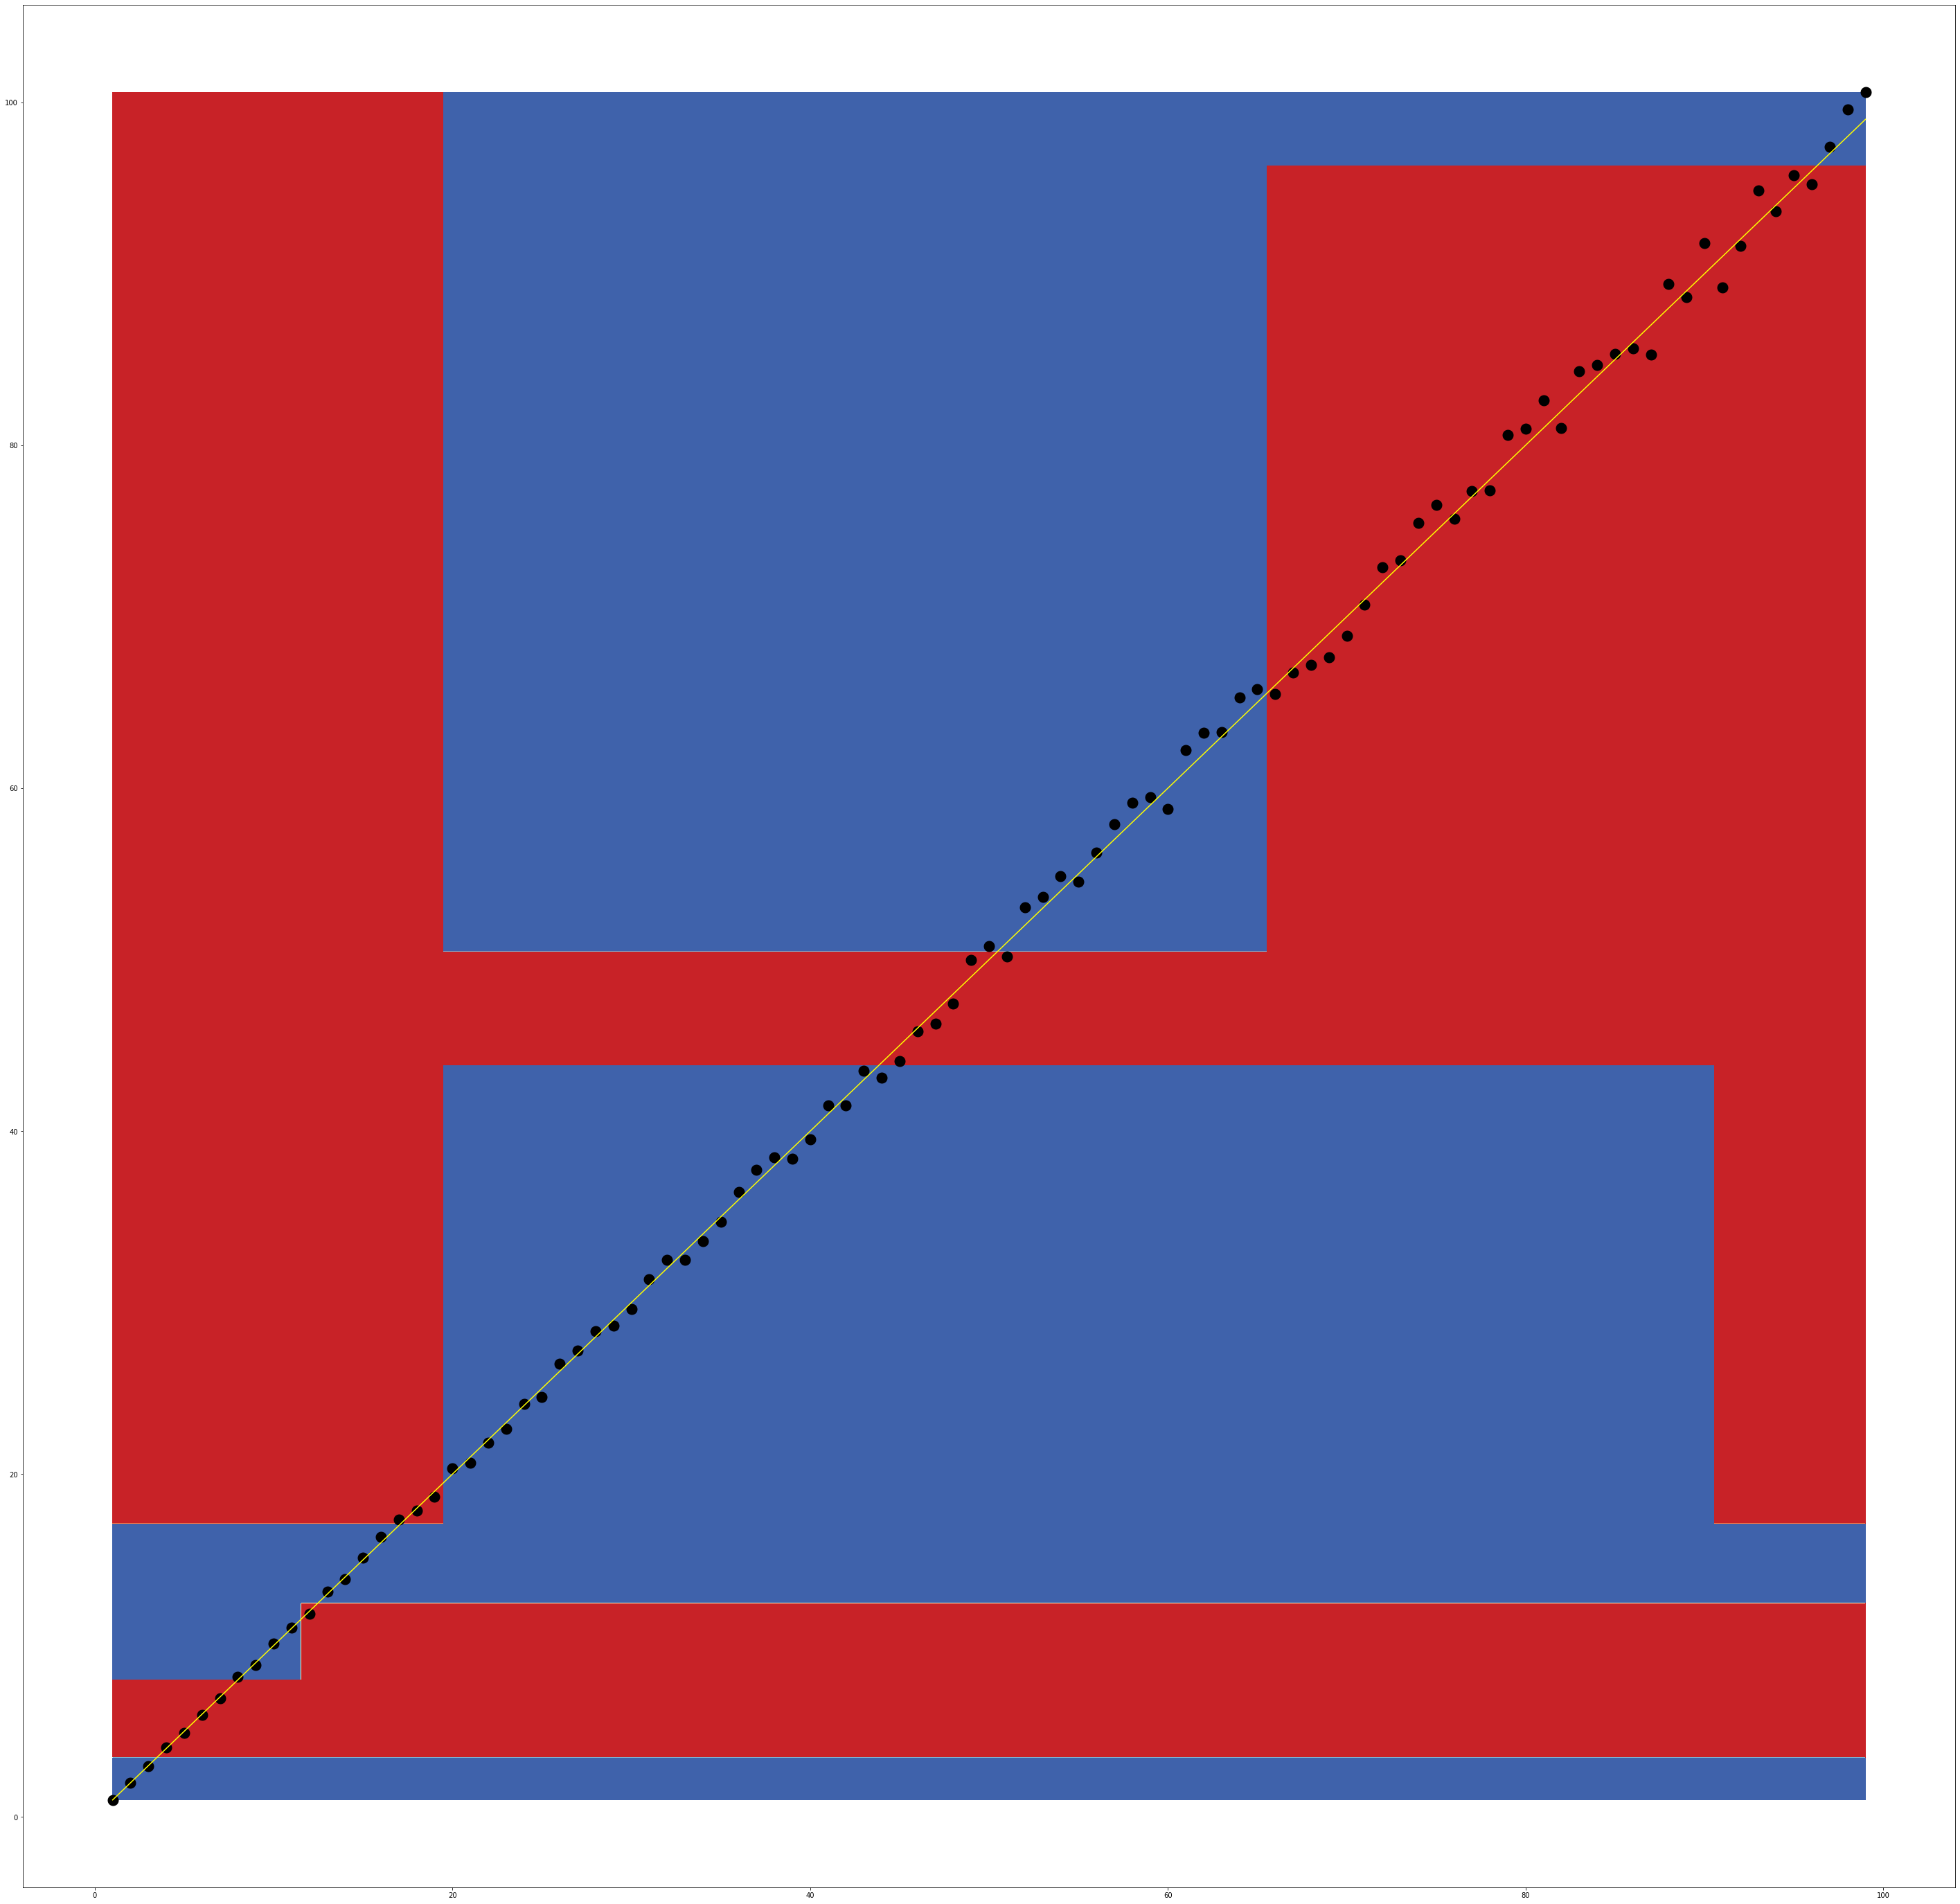

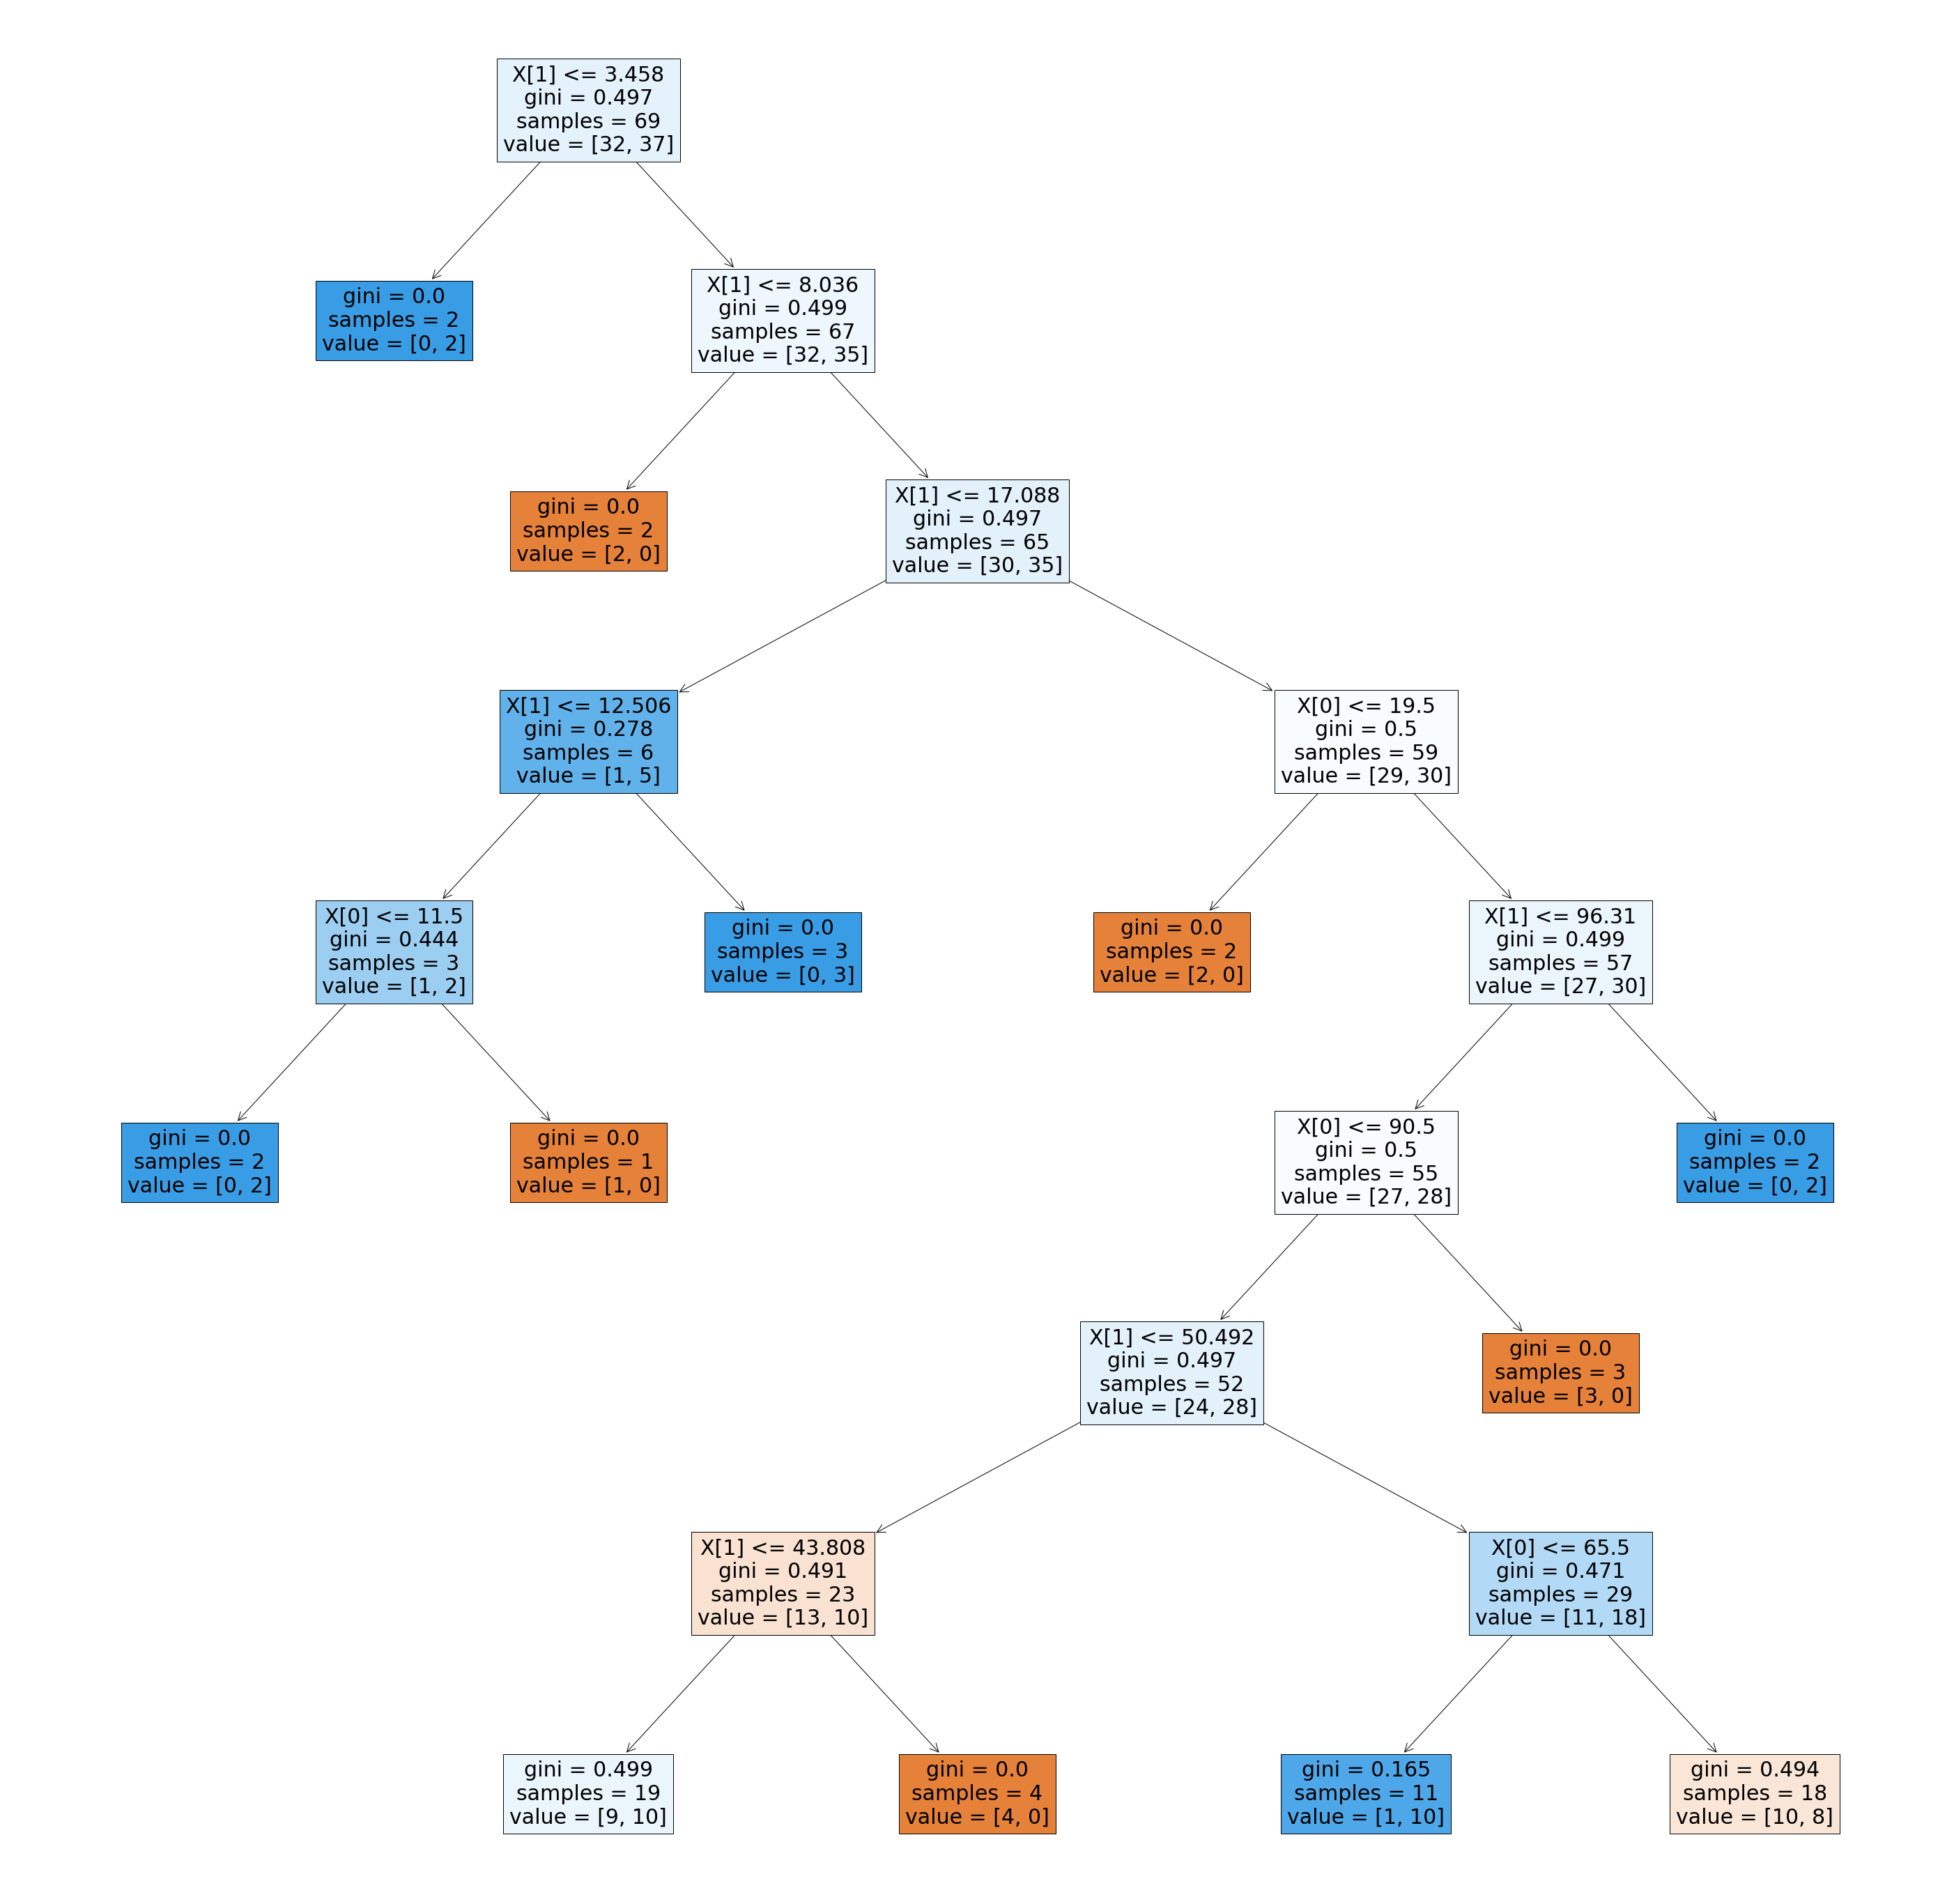

In [72]:
x, y = create_dataset(100)
m_d = 8
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
d_tree = tree.DecisionTreeClassifier(max_depth=m_d)
d_tree = d_tree.fit(x_train, y_train)
d_tree_predict = d_tree.predict(x_test)
#d_tree_accuracy = accuracy_score(y_test, d_tree_predict)
score = d_tree.score(x_test, y_test)
print('DecisionTreeClassifier with max_depth = ',m_d ,' and score = ', score)
#PLOT THE DTREE BOUNDARY
plot_step = 0.02
X=x
Y=y
x_min, x_max = min([a for a,_ in x]), max([a for a,_ in x])
y_min, y_max = min([a for _,a in x]), max([a for _,a in x])
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
Z = d_tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

#Plot points
i = range(1,100,1)
plt.scatter([a for a,_ in x], [a for _,a in x], color='black', linewidths=10 )
plt.plot(i,i, color='yellow')
plt.xticks()
plt.yticks()
plt.figure()
plot_tree(d_tree, filled=True, fontsize=30)
plt.show()



### Implications for R<sup>d</sup>
The situation above details a problem in R<sup>2</sup>, however when looking at R<sup>d</sup> when d (the dimension of 
the problem) increases it becomes more complex for both classifiers. However a linear logistic regression will still be
able to easily classify the data using only a linear increase in complexity. However a decision tree will increase in
complexity exponentially, this is because the tree makes decisions based on one dimension at a time, thus for each
decision made in a dimension there needs to be decisions for other dimensions, consequently as the complexity of the
tree increases so to does the possibility of over-fitting

## 3 Regression on mixed data types


In [73]:
#load csv file
csv_pf = pd.read_csv('assignment1-2019-data.csv')
# display(csv_pf)

# applying one hot encoding
csv_pf_dummy = pd.get_dummies(csv_pf.X4)
csv_pf = csv_pf.join(csv_pf_dummy)
# display(csv_pf)

# format data
subset_X = csv_pf[['X1', 'X2', 'X3','A', 'B', 'C']]
csv_X = [tuple(x) for x in subset_X.values]

subset_Y = csv_pf[['Y']]
csv_Y = [tuple(x) for x in subset_Y.values]
# 
csv_linear = linear_model.LinearRegression()
csv_linear = csv_linear.fit(csv_X, csv_Y)
print('intercept: ', csv_linear.intercept_[0])
print('coefficients: ', list(csv_linear.coef_[0]))
print('rounded coefficients: ', list(round(x) for x in csv_linear.coef_[0]))

csv_pred = csv_linear.predict(csv_X)
print('mean squared error: ', mean_squared_error(csv_Y, csv_pred))
print('R-squared: ', r2_score(csv_Y, csv_pred))

intercept:  7.736846586761651
coefficients:  [0.928272343035385, 2.583901571685625, 2.3090645115763757, 8.524620380747988, -6.2186606943802865, -2.3059596863676948]
rounded coefficients:  [1.0, 3.0, 2.0, 9.0, -6.0, -2.0]
mean squared error:  51.178608246662264
R-squared:  0.6554272705683302


### Case based definition of functions
The linear model identified functions on the

### assigning a predicted value
Upon seeing a new value 